In [1]:
import json
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx
import umap

import torch
import torch.nn.functional as F

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.metrics.pairwise import cosine_similarity

from models import EdgeEncoder, EdgeDecoder

import utils

/sciclone/geograd/stmorse/sgg/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
input_path = '/sciclone/geograd/stmorse/reddit/subreddit/science/filtered'

In [3]:
start_year, end_year = 2007, 2011
start_month, end_month = 1, 12
period = 6

graphs = {}
features = {}

current_key = 0
for year in range(start_year, end_year + 1):
    for month in range(start_month, end_month + 1, period):
        end_period_month = month + period - 1
        end_period_year = year
        if end_period_month > 12:
            end_period_month -= 12
            end_period_year += 1
        if end_period_year > end_year or (end_period_year == end_year and end_period_month > end_month):
            break

        graph_file = f"graph_{year}-{month:02d}_{end_period_year}-{end_period_month:02d}_filtered.json"
        feature_file = f"features_{year}-{month:02d}_{end_period_year}-{end_period_month:02d}_filtered.npy"

        graph_path = os.path.join(input_path, graph_file)
        feature_path = os.path.join(input_path, feature_file)

        if os.path.exists(graph_path):
            with open(graph_path, 'r') as f:
                graphs[current_key] = json.load(f)

        if os.path.exists(feature_path):
            features[current_key] = np.load(feature_path)

        current_key += 1

# visualize co-reply and feature graphs

H: nodes 54 edges 60


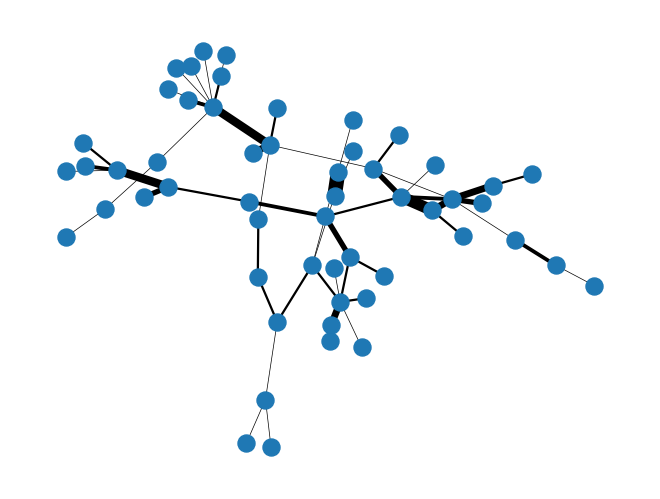

In [16]:
key = 0  # specify the key you want to convert

graph_data = graphs[key]
G = nx.Graph()  # create a graph

# Add nodes
user_to_idx = graph_data['user_to_idx']
for user, idx in user_to_idx.items():
    G.add_node(idx, user=user)

# Add edges
edge_index = graph_data['edge_index']
edge_weights = graph_data['edge_weight']
for i, (src, dst) in enumerate(zip(edge_index[0], edge_index[1])):
    G.add_edge(src, dst, weight=edge_weights[i])

# Filter edges based on weight threshold
weight_threshold = 2
edges_to_keep = [(u, v) for u, v, attr in G.edges(data=True) if attr['weight'] > weight_threshold]
H = G.edge_subgraph(edges_to_keep).copy()

# keep just largest connected component
# largest_cc = max(nx.connected_components(G), key=len)
# H = G.subgraph(largest_cc)
largest_cc = max(nx.connected_components(H), key=len)
H = H.subgraph(largest_cc)

print(f"H: nodes {H.number_of_nodes()} edges {H.number_of_edges()}")

# Generate positions for all nodes using a layout algorithm
pos = nx.spring_layout(H, seed=42)

# Extract weights from each edge in the component
weights = [H[u][v]['weight'] for u, v in H.edges()]

# Optionally, scale edge widths (this scales weights between 0.5 and 5)
min_w, max_w = min(weights), max(weights)
scale = 10 / (max_w - min_w) if max_w != min_w else 1
edge_widths = [(w - min_w) * scale + 0.5 for w in weights]

# Draw the graph with edge widths proportional to their weight
nx.draw(H, pos, with_labels=False, node_size=150, width=edge_widths)
plt.show()

0: nodes 2144 edges 1013
1: nodes 2144 edges 3639


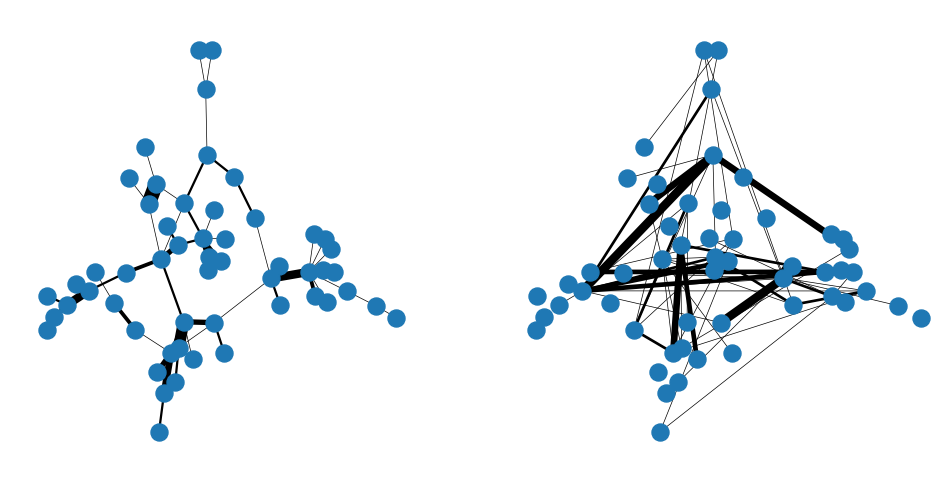

In [17]:
keys = [0, 1]  # specify the keys you want to convert
weight_threshold = 2

Gs = {key: nx.Graph() for key in keys}

# do full graphs
for key in keys:
    user_to_idx = graphs[key]['user_to_idx']
    for user, idx in user_to_idx.items():
        Gs[key].add_node(idx, user=user)

    # Add edges
    edge_index = graphs[key]['edge_index']
    edge_weights = graphs[key]['edge_weight']
    for i, (src, dst) in enumerate(zip(edge_index[0], edge_index[1])):
        Gs[key].add_edge(src, dst, weight=edge_weights[i])

    print(f"{key}: nodes {Gs[key].number_of_nodes()} edges {Gs[key].number_of_edges()}")

# filter first graph
# Filter edges based on weight threshold
# and keep just largest connected component
key = keys[0]
edges_to_keep = [(u, v) for u, v, attr in Gs[key].edges(data=True) if attr['weight'] > weight_threshold]
Gs[key] = Gs[key].edge_subgraph(edges_to_keep)
largest_cc = max(nx.connected_components(Gs[key]), key=len)
Gs[key] = Gs[key].subgraph(largest_cc)

# filter second graph based off first
nodes_to_keep = set(Gs[keys[0]].nodes())
Gs[keys[1]] = Gs[keys[1]].subgraph(nodes_to_keep).copy()

# Generate positions for all nodes using a layout algorithm
pos = nx.spring_layout(Gs[keys[0]], seed=42)

fig, axs = plt.subplots(1,2, figsize=(12,6))

for ax, key in zip(axs, keys):
    H = Gs[key]
    
    # Extract weights from each edge in the component
    weights = [H[u][v]['weight'] for u, v in H.edges()]

    # Optionally, scale edge widths (this scales weights between 0.5 and 5)
    min_w, max_w = min(weights), max(weights)
    scale = 10 / (max_w - min_w) if max_w != min_w else 1
    edge_widths = [(w - min_w) * scale + 0.5 for w in weights]

    # Draw the graph with edge widths proportional to their weight
    nx.draw(H, pos, with_labels=False, node_size=150, width=edge_widths, ax=ax)

plt.show()

(54, 15) (54, 15)


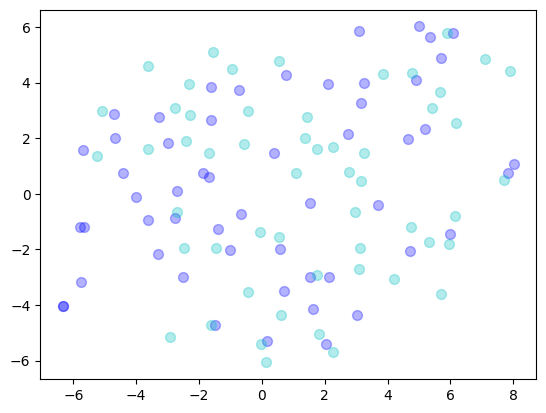

In [18]:
n = len(nodes_to_keep)
x0 = features[keys[0]][list(nodes_to_keep),:]
x1 = features[keys[1]][list(nodes_to_keep),:]
print(x0.shape, x1.shape)

x = np.vstack((x0, x1))
xt = TSNE(n_components=2).fit_transform(x)

plt.scatter(xt[:n,0], xt[:n,1], c='b', s=50, alpha=0.3)
plt.scatter(xt[n:,0], xt[n:,1], c='c', s=50, alpha=0.3)
plt.show()

In [19]:
Hs = {key: nx.Graph() for key in keys}
threshold = 0.8

for key in keys:
    Hs[key].add_nodes_from(nodes_to_keep)

    ntk = list(nodes_to_keep)
    sim_mx = cosine_similarity(features[key][ntk,:])

    for i in range(len(ntk)):
        for j in range(i + 1, len(ntk)):  # Avoid duplicate edges
            if sim_mx[i, j] > threshold:
                Hs[key].add_edge(ntk[i], ntk[j], weight=sim_mx[i, j])

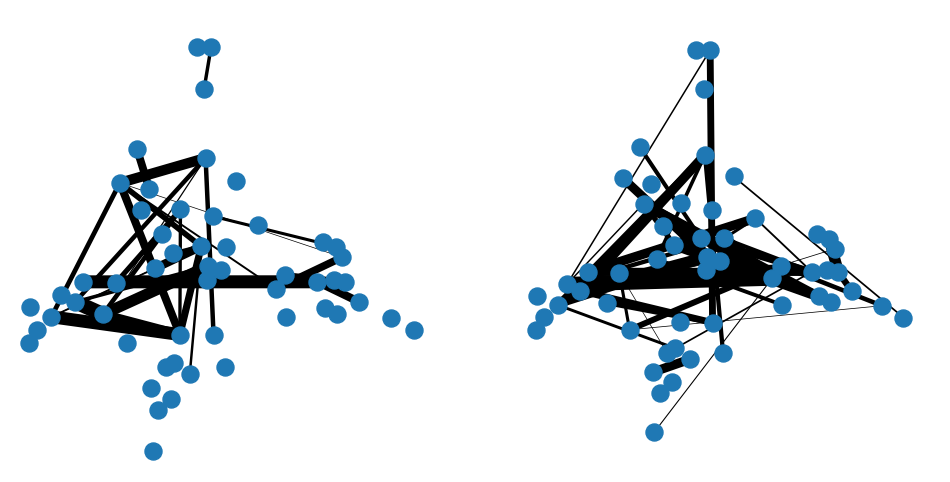

In [20]:
fig, axs = plt.subplots(1,2, figsize=(12,6))

for ax, key in zip(axs, keys):
    H = Hs[key]
    
    # Extract weights from each edge in the component
    weights = [H[u][v]['weight'] for u, v in H.edges()]

    # Optionally, scale edge widths (this scales weights between 0.5 and 5)
    min_w, max_w = min(weights), max(weights)
    scale = 10 / (max_w - min_w) if max_w != min_w else 1
    edge_widths = [(w - min_w) * scale + 0.5 for w in weights]

    # Draw the graph with edge widths proportional to their weight
    nx.draw(H, pos, with_labels=False, node_size=150, width=edge_widths, ax=ax)

plt.show()

# check similarity of co-reply and feature graphs

In [14]:
def compute_auc(graph_data, feature_matrix):
    # Helper function to compute cosine similarity between two vectors
    def cosine_sim(vec1, vec2):
        return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

    # Extract graph data
    edge_index = graph_data['edge_index']
    num_nodes = feature_matrix.shape[0]

    # Prepare labels and predictions
    labels = []
    predictions = []

    # Positive edges
    src_nodes = edge_index[0]
    dst_nodes = edge_index[1]
    labels.extend([1] * len(src_nodes))  # Positive edges
    predictions.extend(cosine_similarity(feature_matrix[src_nodes], feature_matrix[dst_nodes]).diagonal())

    # Negative edges (non-existent edges)
    all_pairs = np.array(np.meshgrid(range(num_nodes), range(num_nodes))).T.reshape(-1, 2)
    existing_edges = set(zip(edge_index[0], edge_index[1]))
    negative_edges = [pair for pair in all_pairs if pair[0] != pair[1] and tuple(pair) not in existing_edges]

    negative_edges = np.array(negative_edges)
    labels.extend([0] * len(negative_edges))  # Negative edges
    predictions.extend(cosine_similarity(feature_matrix[negative_edges[:, 0]], feature_matrix[negative_edges[:, 1]]).diagonal())

    # Compute AUC (ROC) score
    auc_score = roc_auc_score(labels, predictions)
    return auc_score

# visualize latent space

In [7]:
def get_edge_latents(graph_json_path, feature_npy_path, model_pth_path, device='cpu', edge_latent_dim=32):
    """
    Returns:
      edge_index: torch.LongTensor of shape [2, E], the (u,v) pairs
      z_uv:       np.ndarray of shape [E, latent_dim], edge embeddings
      scores:     np.ndarray of shape [E], decoder’s edge-existence probabilities
    """
    # 1) Load graph & features
    with open(graph_json_path, 'r') as f:
        g = json.load(f)
    edge_index = torch.tensor(g['edge_index'], dtype=torch.long, device=device)
    x = torch.tensor(np.load(feature_npy_path), dtype=torch.float, device=device)

    # 2) Instantiate & load model
    num_nodes, in_dim = x.shape
    encoder     = EdgeEncoder(in_channels=in_dim, hidden_channels=64, edge_latent_dim=edge_latent_dim).to(device)
    # edge_decoder= EdgeDecoder(edge_latent_dim=32).to(device)
    ckpt = torch.load(model_pth_path, map_location=device)
    encoder.load_state_dict(ckpt['enc'])
    # edge_decoder.load_state_dict(ckpt['ed'])
    
    encoder.eval(); 
    # edge_decoder.eval()

    # 3) Node‐level encoding
    h = F.relu(encoder.gcn1(x, edge_index, None))
    h = F.relu(encoder.gcn2(h, edge_index, None))

    # 4) Build edge embeddings
    src, dst = edge_index
    z_input = torch.cat([h[src], h[dst]], dim=1)
    z_uv = encoder.edge_mlp(z_input)

    # 5) Decode edge scores
    # with torch.no_grad():
    #     scores = edge_decoder(z_uv)

    return edge_index.cpu(), z_uv.detach().cpu().numpy(), 
        # scores.cpu().numpy()

In [8]:
def sample_negative_edges(num_nodes, pos_set, num_samples, device):
    neg = set()
    while len(neg) < num_samples:
        cand = torch.randint(0, num_nodes, (num_samples*2, 2), device=device).tolist()
        for u, v in cand:
            if u == v or (u,v) in pos_set or (v,u) in pos_set:
                continue
            neg.add((u, v))
            if len(neg) >= num_samples:
                break
    src = torch.tensor([u for u,v in neg], dtype=torch.long, device=device)
    dst = torch.tensor([v for u,v in neg], dtype=torch.long, device=device)
    return torch.stack([src, dst], dim=0)

def get_edge_latents_with_negatives(
    graph_json_path,
    feature_npy_path,
    model_pth_path,
    device='cpu',
    neg_ratio=1.0,
    edge_latent_dim=32,
):
    """
    Returns:
      pos_edge_index: Tensor [2, E_pos]
      z_pos:          np.ndarray [E_pos, D]
      scores_pos:     np.ndarray [E_pos]
      neg_edge_index: Tensor [2, E_neg]
      z_neg:          np.ndarray [E_neg, D]
      scores_neg:     np.ndarray [E_neg]
    """
    # Load graph & features
    g = json.load(open(graph_json_path))
    edge_index = torch.tensor(g['edge_index'], dtype=torch.long, device=device)
    x = torch.tensor(np.load(feature_npy_path), dtype=torch.float, device=device)

    # Model init & load
    in_dim = x.size(1)
    encoder = EdgeEncoder(in_channels=in_dim, hidden_channels=64, edge_latent_dim=edge_latent_dim).to(device)
    decoder = EdgeDecoder(edge_latent_dim=edge_latent_dim).to(device)
    ckpt = torch.load(model_pth_path, map_location=device)
    encoder.load_state_dict(ckpt['enc'])
    decoder.load_state_dict(ckpt['ed'])
    encoder.eval(); decoder.eval()

    # Node encoding
    with torch.no_grad():
        h = F.relu(encoder.gcn1(x, edge_index, None))
        h = F.relu(encoder.gcn2(h, edge_index, None))

    # Positive edges
    src_pos, dst_pos = edge_index
    pos_set = set(zip(src_pos.tolist(), dst_pos.tolist()))
    z_pos = encoder.edge_mlp(torch.cat([h[src_pos], h[dst_pos]], dim=1))
    with torch.no_grad():
        scores_pos = decoder(z_pos)

    # Negative edges
    n_pos = src_pos.size(0)
    edge_neg = sample_negative_edges(x.size(0), pos_set, int(n_pos*neg_ratio), device)
    src_neg, dst_neg = edge_neg
    z_neg = encoder.edge_mlp(torch.cat([h[src_neg], h[dst_neg]], dim=1))
    with torch.no_grad():
        scores_neg = decoder(z_neg)

    return {
        'pos_edge_index': edge_index.cpu(),
        'z_pos':          z_pos.detach().cpu().numpy(),
        'scores_pos':     scores_pos.detach().cpu().numpy(),
        'neg_edge_index': edge_neg.cpu(),
        'z_neg':          z_neg.detach().cpu().numpy(),
        'scores_neg':     scores_neg.detach().cpu().numpy(),
    }

In [9]:
res = get_edge_latents_with_negatives(
    os.path.join(input_path, 'graph_2007-01_2007-06_filtered.json'),
    os.path.join(input_path, 'features_2007-01_2007-06_filtered.npy'),
    os.path.join(input_path, 'best_model.pth'),
    edge_latent_dim=2,
)

In [10]:
res['pos_edge_index'].shape

torch.Size([2, 1013])

In [11]:
res['pos_edge_index'][:,:5]

tensor([[ 512,  845,  646,  646, 1190],
        [1011, 1879,  845, 1879, 1831]])

In [12]:
features[0].shape

(2144, 15)

In [13]:
res['z_pos'].shape, res['z_neg'].shape

((1013, 2), (1013, 2))

In [14]:
zc = np.vstack((res['z_pos'], res['z_neg']))
# zuvt = TSNE(n_components=2).fit_transform(zc)
zuvt = zc.copy()
zuvt.shape

(2026, 2)

In [21]:
# Extract the source and destination nodes from pos_edge_index
src_nodes, dst_nodes = res['pos_edge_index']
print(src_nodes.shape, dst_nodes.shape)

# Find indices where both source and destination nodes are in nodes_to_keep
pos_indices = np.array([
    i for i, (src, dst) in enumerate(zip(src_nodes.tolist(), dst_nodes.tolist()))
    if src in nodes_to_keep and dst in nodes_to_keep
])

# Extract the source and destination nodes from pos_edge_index
src_nodes, dst_nodes = res['neg_edge_index']
print(src_nodes.shape, dst_nodes.shape)

# Find indices where both source and destination nodes are in nodes_to_keep
neg_indices = np.array([
    i for i, (src, dst) in enumerate(zip(src_nodes.tolist(), dst_nodes.tolist()))
    if src in nodes_to_keep and dst in nodes_to_keep
])

print(pos_indices.shape, neg_indices.shape)

torch.Size([1013]) torch.Size([1013])
torch.Size([1013]) torch.Size([1013])
(121,) (0,)


In [24]:
len(nodes_to_keep)

54

In [52]:
noi = list(nodes_to_keep)[17]
print(noi)

src_nodes, dst_nodes = res['pos_edge_index']
noi_pos_indices = np.array([
    i for i, (src, dst) in enumerate(zip(src_nodes.tolist(), dst_nodes.tolist()))
    if src == noi or dst == noi
])

src_nodes, dst_nodes = res['neg_edge_index']
noi_neg_indices = np.array([
    i for i, (src, dst) in enumerate(zip(src_nodes.tolist(), dst_nodes.tolist()))
    if src == noi or dst == noi
])

print(noi_pos_indices.shape, noi_neg_indices.shape)

687
(7,) (2,)


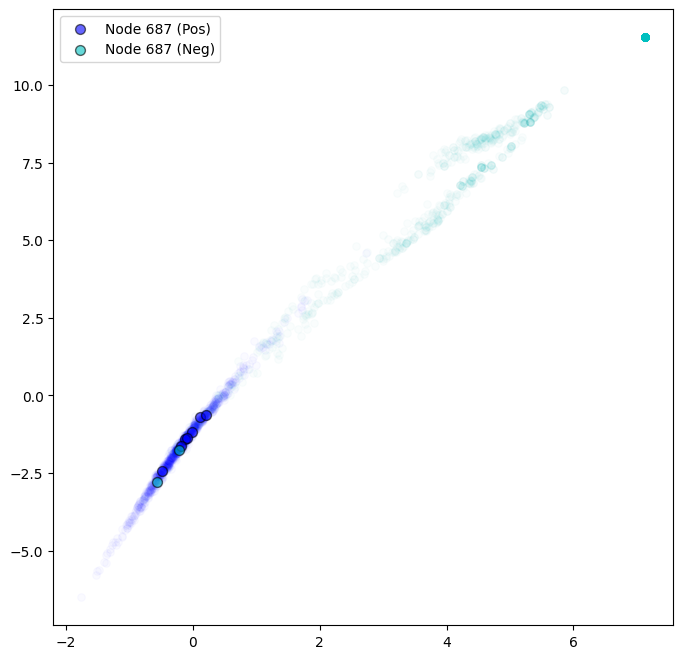

In [57]:
fig, ax = plt.subplots(1,1, figsize=(8,8))

n = res['z_pos'].shape[0]
ax.scatter(zuvt[:n,0], zuvt[:n,1], s=30, c='b', alpha=0.02)
ax.scatter(zuvt[n:,0], zuvt[n:,1], s=30, c='c', alpha=0.02)

# ax.scatter(zuvt[pos_indices,0], zuvt[pos_indices,1], s=40, c='b', alpha=0.6)

ax.scatter(zuvt[noi_pos_indices,0], zuvt[noi_pos_indices,1], s=50, c='b', alpha=0.6, label=f'Node {noi} (Pos)', edgecolors='black', linewidth=1)
ax.scatter(zuvt[noi_neg_indices,0], zuvt[noi_neg_indices,1], s=50, c='c', alpha=0.6, label=f'Node {noi} (Neg)', edgecolors='black', linewidth=1)

ax.legend()
plt.show()


# check against baseline

In [5]:
for i in range(len(graphs)-1):
    t0, t1 = i, i+1
    
    # Extract edges from graphs[0] and graphs[1]
    edges_0 = set(zip(graphs[t0]['edge_index'][0], graphs[t0]['edge_index'][1]))
    edges_1 = set(zip(graphs[t1]['edge_index'][0], graphs[t1]['edge_index'][1]))

    # Create a binary prediction for edges in graphs[1]
    num_nodes = len(graphs[t0]['user_to_idx'])
    all_possible_edges = set((i, j) for i in range(num_nodes) for j in range(num_nodes) if i != j)

    # Positive edges
    positive_edges = list(edges_1)
    num_positive_edges = len(positive_edges)

    # Negative edges: edges in all_possible_edges but not in edges_1
    negative_edges = list(all_possible_edges - edges_1)
    sampled_negative_edges = np.random.choice(len(negative_edges), num_positive_edges, replace=False)
    negative_edges = [negative_edges[i] for i in sampled_negative_edges]

    # Combine positive and sampled negative edges
    all_edges = positive_edges + negative_edges
    actual_labels = [1] * num_positive_edges + [0] * num_positive_edges
    predicted_labels = [1 if edge in edges_0 else 0 for edge in all_edges]

    # Convert to tensors
    predicted_labels = torch.tensor(predicted_labels, dtype=torch.float)
    actual_labels = torch.tensor(actual_labels, dtype=torch.float)

    # Compute BCE loss
    bce_loss = F.binary_cross_entropy(predicted_labels, actual_labels)
    print(f"BCE Loss {t0}-{t1}: {bce_loss.item()}")

BCE Loss 0-1: 49.519100189208984
BCE Loss 1-2: 49.181617736816406
BCE Loss 2-3: 48.290428161621094
BCE Loss 3-4: 48.3681755065918
BCE Loss 4-5: 48.560672760009766
BCE Loss 5-6: 48.40996551513672
BCE Loss 6-7: 48.36219787597656
BCE Loss 7-8: 48.754207611083984
BCE Loss 8-9: 48.91411590576172


# visualizing topic clusters

In [4]:
basepath = '/sciclone/geograd/stmorse/reddit'

In [5]:
yr, mo = 2008, 6

metadata = pd.read_csv(
    os.path.join(basepath, f'metadata/metadata_{yr}-{mo:02}.csv'), 
    compression='gzip')

with open(os.path.join(basepath, f'embeddings/embeddings_{yr}-{mo:02}.npz'), 'rb') as f:
    embeddings = np.load(f)['embeddings']
print(embeddings.shape)

idx = np.where(metadata['subreddit']=='science')[0]
embeddings = embeddings[idx,:]
print(embeddings.shape)

with open(os.path.join(basepath, f'subreddit/science/labels/labels_{yr}-{mo:02}.npz'), 'rb') as f:
    labels = np.load(f)['labels']
print(labels.shape)

with open(os.path.join(basepath, f'subreddit/science/tfidf/tfidf_2007-2011.pkl'), 'rb') as f:
    tfidf = pickle.load(f)
tfidf.keys()

(387632, 384)
(21722, 384)
(21722,)


dict_keys(['range', 'full', 'tfidf'])

In [15]:
for c in range(len(np.unique(labels))):
    print(f'{c}: {' '.join([kw for kw in tfidf['tfidf'][c]['keywords'][:10]])}')

0: ki4u nuclearsurvival ares hamas qaeda wtc7 nuking taliban icbms firepower
1: trekkie oveur norris fhtagn zoidberg 3fv dunn weeee lyrics bom
2: renewables geothermal kwh pv turbine photovoltaics mw photovoltaic reprocessing nanosolar
3: que argumentum urbandictionary stereotyping corsican apostrophes derogatory taliban toi spammer
4: electrolytes carbohydrates cholesterol sucrose lactose garlic carbohydrate lard broccoli strawberry
5: wages monopolies charities scholarships subsidy roi bailouts homeschooling medicare taxed
6: skepticalscience scientific_opinion_on_climate_change climatology sunspots precipitation ar4 wg1 albedo aerosols mwp
7: lesbians uncircumcised genitalia clitoris nipples fetishes slut pelvic ejaculation libido
8: wikileaks this_aint_science_fiction_its_just_science e6zv5 k0dgn anticancer_virus_shows_promise_an_engineered enquirer linkjacked plagiarism editorializing lindzen
9: zoos triceratops penguins invertebrates speciation reptile octopuses genus torosaurus 

In [56]:
kws = [
    'nuclear',
    'sci-fi',
    'renewable energy',
    'argument',
    'health',
    'subsidies',
    'climate debate',
    'sex-related',
    'conspiracy',
    'animals',
    'vaccines',
    'drugs',
    'ads',
    'cosmology',
    'evolution debate',
]
print(len(kws))

15


In [18]:
# embed_t = TSNE(
#     n_components=2, 
#     perplexity=50,
#     early_exaggeration=12,
# ).fit_transform(embeddings)
embed_t = umap.UMAP(
    n_components=2,
    n_neighbors=20,
).fit_transform(embeddings)

/sciclone/geograd/stmorse/sgg/venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


/local/scr/stmorse/TMPDIR/ipykernel_2105246/1346692265.py:11: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(


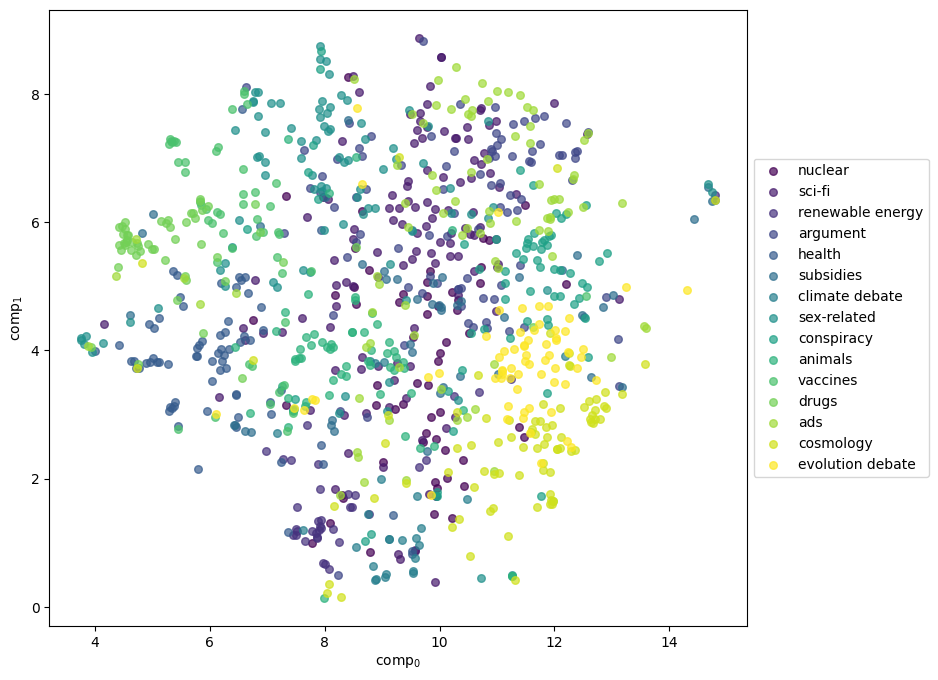

In [23]:
fig, ax = plt.subplots(1,1, figsize=(9,8))

n_clusters = len(np.unique(labels))
colors = plt.cm.viridis(np.linspace(0, 1, n_clusters))
np.random.seed(314)
ridx = np.random.choice(len(embed_t), size=1000, replace=False)

for c in range(n_clusters):
    ix = np.where(labels == c)[0]
    ix = np.intersect1d(ridx, ix)
    ax.scatter(
        embed_t[ix, 0], embed_t[ix, 1],
        s=30, c=colors[c], alpha=0.7, 
        # label=tfidf['tfidf'][c]['keywords'][1],
        label=kws[c]
    )

ax.set_xlabel('$\\text{comp}_0$')
ax.set_ylabel('$\\text{comp}_1$')    
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


# check out sample sentences

In [25]:
basepath = '/sciclone/geograd/stmorse/reddit'

In [ ]:
yr, mo = 2007, 4

metadata = pd.read_csv(
    os.path.join(basepath, f'metadata/metadata_{yr}-{mo:02}.csv'), 
    compression='gzip')

with open(os.path.join(basepath, f'subreddit/science/labels/labels_{yr}-{mo:02}.npz'), 'rb') as f:
    labels = np.load(f)['labels']
print(labels.shape)

user_counts = pd.read_csv(os.path.join(basepath, f'subreddit/science/users/user_counts_{yr}-01_{yr}-06.csv'))
user_counts.head()

(2636,)


,author,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,09F911029D74E3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,0ntarget,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,1101010001,0,0,2,0,0,1,0,1,0,1,0,0,0,0,0
4,1492,0,0,0,0,0,0,1,4,0,0,0,0,0,0,0


In [52]:
# Calculate total posts for each author
user_counts['total_posts'] = user_counts.iloc[:, 1:].sum(axis=1)

# Determine the threshold for the top 1%
threshold = user_counts['total_posts'].quantile(0.99)

# Get authors in the top 1%
top_authors = user_counts[user_counts['total_posts'] >= threshold]['author'].tolist()
print(f"Number of authors in the top 1%: {len(top_authors)}")

Number of authors in the top 1%: 38


In [79]:
aoi = top_authors[6]
print(aoi)

Prysorra


In [80]:
metadata.query("author == @aoi & subreddit == 'science'").shape

(11, 7)

In [81]:
user_counts.query("author == @aoi")

,author,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,total_posts
485,Prysorra,4,1,2,1,4,1,3,1,2,11,5,9,4,0,3,51


In [89]:
z = user_counts.query("author == @aoi").iloc[:,1:-1].to_numpy().flatten()
print(z)
z = z / np.linalg.norm(z)
print('  '.join([f'{w:.2f}' for w in z]))

[ 4  1  2  1  4  1  3  1  2 11  5  9  4  0  3]
0.23  0.06  0.11  0.06  0.23  0.06  0.17  0.06  0.11  0.63  0.29  0.52  0.23  0.00  0.17


In [82]:
# need to figure out indices of top 3 clusters
# these are indices within the subreddit
top_clusters = list(range(15))
top_cluster_indices = {idx: np.where(labels == idx)[0] for idx in top_clusters}

# get subreddit indices
subreddit_indices = metadata.query("subreddit == 'science'")['idx'].to_numpy()

# need to figure out indices of author
# these are indices within the entire month
author_idxs = metadata.query("author == @aoi & subreddit == 'science'")['idx'].to_numpy()

# loop through and intersect these
author_cluster_idxs = {
    idx: np.intersect1d(subreddit_indices[top_cluster_indices[idx]], author_idxs) for idx in top_clusters}

# these are indices within the entire month
print(author_cluster_idxs)

{0: array([52754, 68633]), 1: array([48833]), 2: array([], dtype=int64), 3: array([68072]), 4: array([], dtype=int64), 5: array([85066]), 6: array([], dtype=int64), 7: array([27188]), 8: array([], dtype=int64), 9: array([49228]), 10: array([], dtype=int64), 11: array([52759]), 12: array([46585]), 13: array([25499]), 14: array([14152])}


In [84]:
sentences = utils.read_file(
    yr, mo, 
    return_type='sentences', 
    chunk_size=10000
)

k = 0
for chunk in sentences:
    for sentence in chunk:
        for c_idx, idx in author_cluster_idxs.items():
            if k in idx:
                print(f'{c_idx} ({kws[c_idx]}): {sentence}')
        k += 1

debug /sciclone/data10/twford/reddit/reddit/comments/RC_2007-04.bz2
14 (evolution debate): Psychology is treating the "mind" as software.  Neuroscience is treating the brain as hardware.

/quote at will


13 (cosmology): Human understanding of time cannot be complete as long as our experience *of* it is limited to living *through* it.

(Shakes 8ball again)

"No".
7 (sex-related): The sudden reduction of pain is a powerful simulacrum of pleasure.

That's why relieving bladder pressure feels soooooo much better when you *really* had to go.
12 (ads): Yet :|
1 (sci-fi): Fuck!  Time Cub(beaten by an angry horde)
9 (animals): Meta-organism != organism.

The title make a good quote, but the implications of a city as an organism in and of itself are far more outlandish, and far-reaching that what the article was written for.

/prophecy
0 (nuclear): Agreed.  It's like there's an anti-progressive monster inside California struggling to get out.  :-(
11 (drugs): Uhhh....for me yes.  I want the dr